<h1 align="center">Creating a fake experiment</h1> 



In [11]:
%pylab inline
plt.style.use('ggplot')

from scipy.signal import convolve2d 
from scipy import stats
import hrf_estimation as he
import pandas as pd

from pylab import rcParams
rcParams['figure.figsize'] = 13, 10

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [12]:
class Voxel(np.ndarray):
    import warnings

    def __new__(cls, input_array, coords=None):
        obj = np.asarray(input_array).view(cls)
        if coords == None:
            warnings.warn('no coordinates passed')
        elif len(coords) != 3:
            warnings.warn('coords should be in 3 dimensions')
        obj.coords = coords
    
            
            
        obj.coords = coords
        # Finally, we must return the newly created object:
        return obj

    def __array_finalize__(self, obj):
        # see InfoArray.__array_finalize__ for comments
        if obj is None: return
        self.info = getattr(obj, 'info', None)

## Parameters for creating the experiment

In [13]:
TR = 1.0
n_vols = 200
n_stims = 10
hrf_len = 20
TRperStim = 4
beta_range = (0,100)
noise_sigma = 5
n_voxels = 10

## Creating a random design matrix

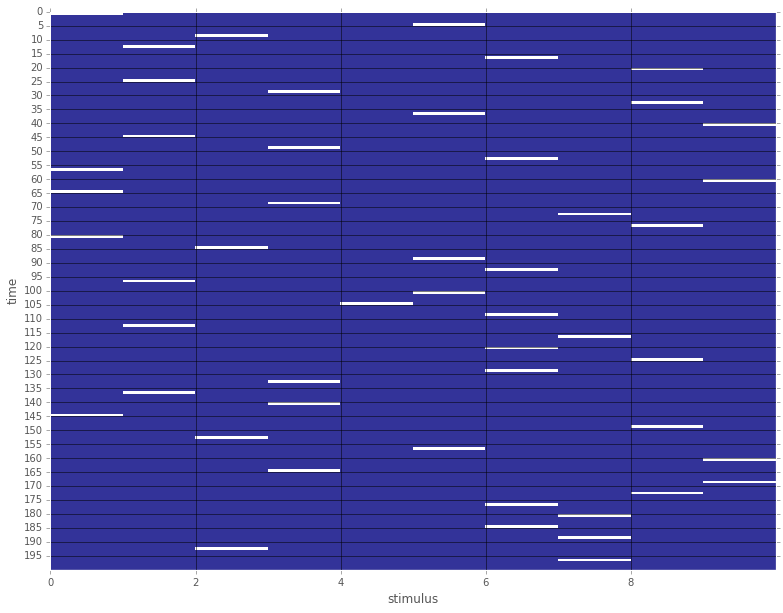

In [17]:
import mpld3
mpld3.enable_notebook()

time = np.arange(0,n_vols*TR,TR)
design_matrix = zeros((n_vols,n_stims))
last = -1
count = 0
for row in design_matrix:
    if count % TRperStim == 0:
        ran = randint(0,n_stims)
        while ran == last:
            ran = randint(0,n_stims)
        row[ran] = 1
        last = ran
    count +=1
plt.xlabel('stimulus')
plt.ylabel('time')
plt.yticks(np.arange(0,n_vols,TR*5))
plt.xticks(np.arange(0,n_stims,2))
plt.grid(color='k')
plt.imshow(design_matrix,interpolation ='none',
           cmap = 'terrain',
           extent = (0,n_stims,n_vols * TR,0),
           aspect = 'auto',
           label='design matrix'
          )
plt.show()

# HRF

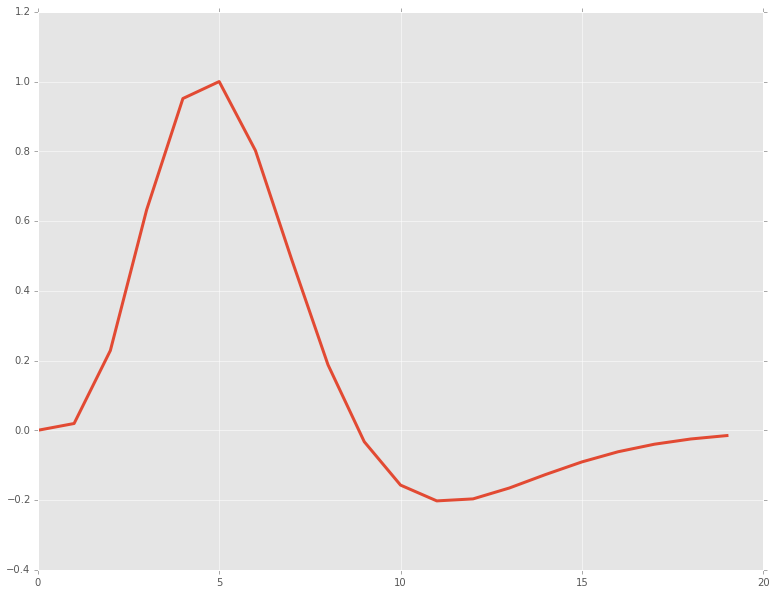

In [19]:
import mpld3
mpld3.enable_notebook()

t = np.arange(hrf_len)
h = stats.gamma.pdf(t,6) - .5*stats.gamma.pdf(t,10) #- np.cos(t) * .1 + np.sin(t) * .3
h = h.reshape(hrf_len,1)
h =  h / max(h)
plt.plot(h,lw=3)
plt.show(True)





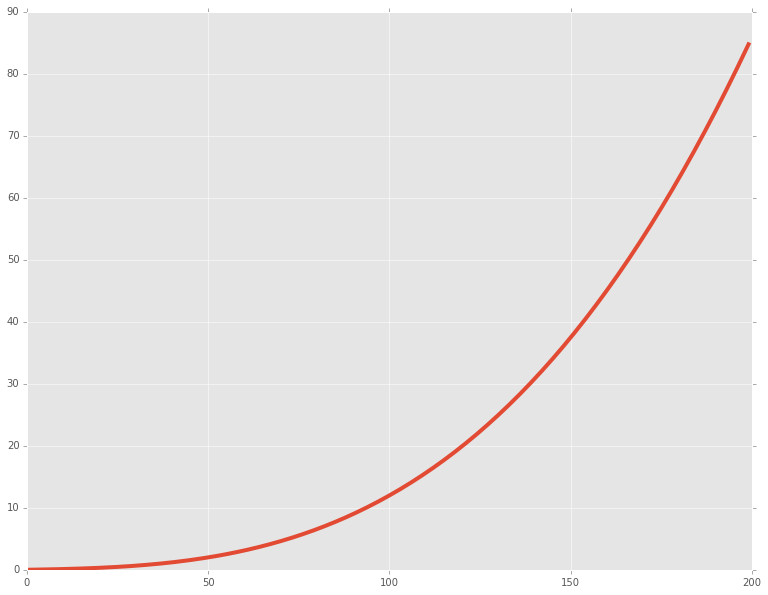

In [20]:
rcParams['figure.figsize'] = 13, 10

t_arange = np.arange(n_vols)

t_trend = t_arange 
t_trend2 = t_arange ** 2 * .01
t_trend3 = t_arange ** 3 * .001

t_to_add= t_trend + t_trend2 + t_trend3
t_to_add /= beta_range[1]
plot(t_to_add,lw=4)

# Signal Creation
* design matrix and HRF shown above
* beta weights are a vector of random integers of length number of stimulus
* noise is a normally distributed vector of random numbers of length number of vols

 * and r = dot(convolve2d(design_matrix,HRF),betas) + noise

 * r = (X * H)^T B + N
 
 
* Add a linear trend too? 

(0, 2, 3)
(1, 2, 3)
(2, 2, 3)
(3, 2, 3)
(4, 2, 3)
(5, 2, 3)
(6, 2, 3)
(7, 2, 3)
(8, 2, 3)
(9, 2, 3)


/home/nick/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


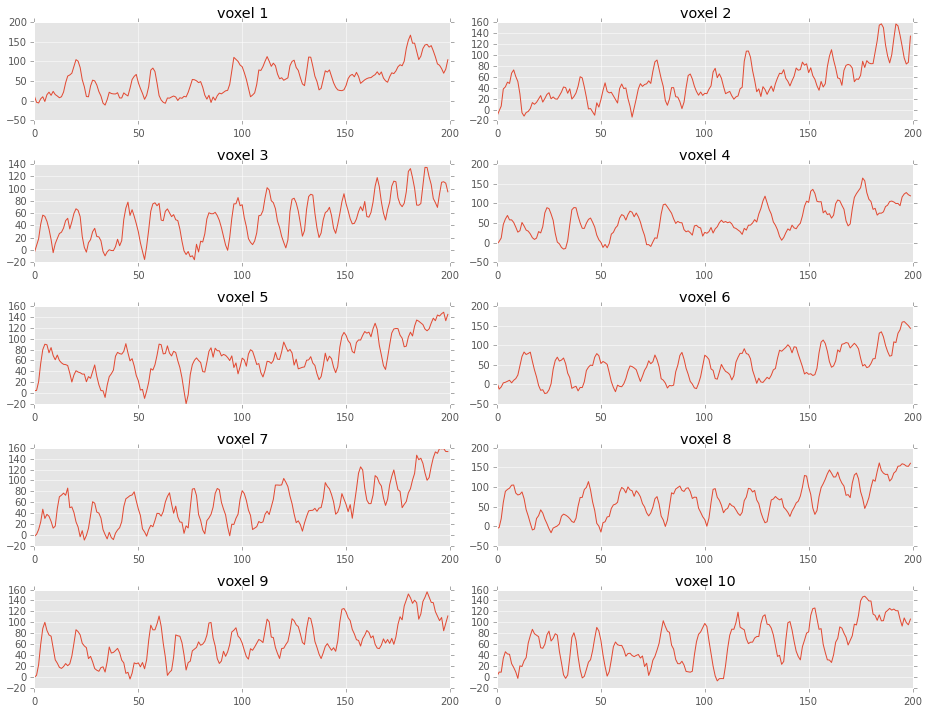

In [21]:
voxels = []
all_betas = []

vfig = plt.figure()


## add a polynomail trend
for _ in xrange(n_voxels):
    betas = np.random.randint(beta_range[0],beta_range[1],n_stims).reshape(n_stims,)
    xStarH = convolve2d(design_matrix,h)
    xhb = np.dot(xStarH,betas)
    #gotta crop the last 9, added from hrf?
    epsilon = np.random.normal(0,noise_sigma,n_vols)

    
    r = xhb[:n_vols] + epsilon.reshape(n_vols,) + t_to_add
    voxels.append(Voxel(r,coords=(_,2,3)))
    all_betas.append(betas.T)
    ax = plt.subplot(np.ceil(n_voxels/2.),2,_ + 1)
    ax.set_title('voxel {}'.format(_ + 1))
    ax.plot(r)
vfig.tight_layout()
vfig.show()

for i in voxels:
    print i.coords

In [22]:
cond_info_1 = np.array([argmax(i) for i in design_matrix][0::TRperStim])
cond_info_2 = np.arange(0,n_vols* TR,TR * TRperStim)

df = pd.DataFrame()
df['voxels'] = voxels
df['betas'] = all_betas
df['cond_seq'] = [cond_info_1 for _ in voxels]
df['cond_onsets'] = [cond_info_2 for _ in voxels]

df

,voxels,betas,cond_seq,cond_onsets
0,"[11.1335659807, -3.80606617322, -5.48833294965...","[5, 66, 11, 7, 75, 15, 98, 50, 30, 22]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
1,"[-11.7559822598, -2.42286911134, 6.26134411253...","[50, 21, 4, 44, 41, 64, 20, 94, 26, 2]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
2,"[-3.7108356656, 7.21985816733, 18.2568470931, ...","[58, 45, 40, 0, 53, 6, 78, 2, 6, 68]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
3,"[-3.67643315752, 2.98803263049, 11.8598392458,...","[67, 19, 53, 1, 44, 36, 39, 25, 93, 77]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
4,"[4.62528085537, 5.05507084411, 21.1462814356, ...","[83, 53, 74, 8, 38, 72, 54, 75, 39, 79]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
5,"[4.30207619382, -11.8194926042, -6.2237945711,...","[9, 67, 76, 52, 44, 3, 0, 64, 0, 49]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
6,"[-2.18847164004, 1.20358401703, 10.0663702877,...","[41, 69, 84, 17, 26, 11, 32, 83, 7, 70]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
7,"[-5.73033263774, -2.87917258365, 19.5154742831...","[94, 11, 88, 37, 31, 92, 59, 85, 2, 93]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
8,"[-0.780529104718, 2.97139182599, 22.4956309721...","[95, 38, 32, 23, 62, 53, 93, 57, 56, 12]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."
9,"[1.79959161932, 8.77489509413, 8.68650450515, ...","[49, 86, 33, 10, 1, 2, 67, 51, 93, 46]","[0, 5, 2, 1, 6, 8, 1, 3, 8, 5, 9, 1, 3, 6, 0, ...","[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ..."


# Design Matrix Creation

[0 5 2 1 6 8 1 3 8 5 9 1 3 6 0 9 0 3 7 8 0 2 5 6 1 5 4 6 1 7 6 8 6 3 1 3 0
 8 2 5 9 3 9 8 6 7 6 7 2 7]


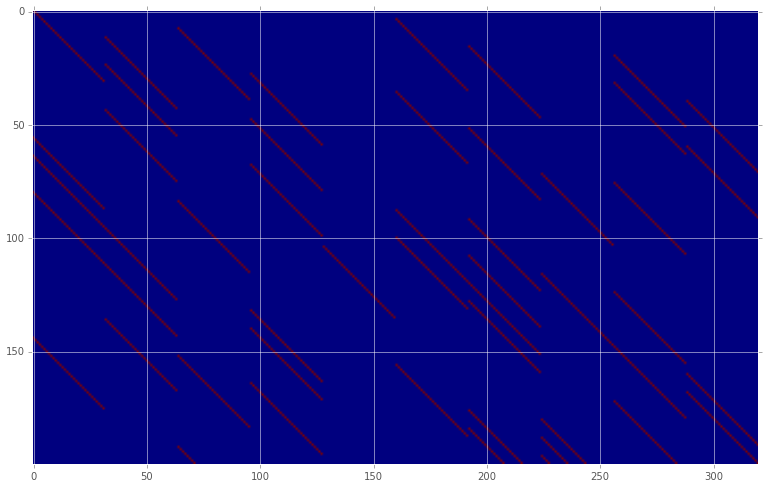

In [23]:
cond_seq = df['cond_seq'].iloc[0]
cond_ons = df['cond_onsets'].iloc[0]

n_scans = n_vols
des_mat, basis = he.create_design_matrix(cond_seq,cond_ons,TR = float(TR),n_scans=n_scans, basis = 'fir')
# plt.imshow(des_mat,interpolation='none',aspect = 'auto')
print cond_seq
plt.imshow(des_mat)

# Detrending

Performed detrending of the BOLD timecourse using a Savitzky-Golay filter


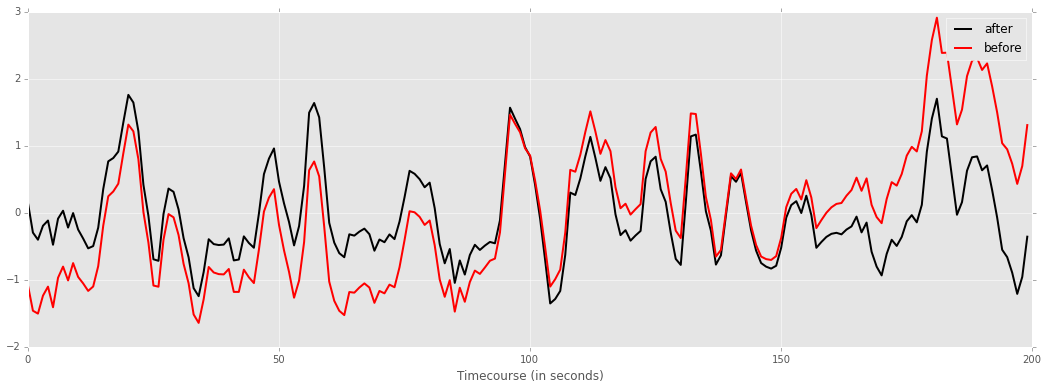

In [24]:
### perform detrending: Savitzky-Golay filter
window_length = 91 ##<<play with this. 
poly_order = 3 ##<<mess with this too
def do_detrend(vox):
    filt =  he.savitzky_golay.savgol_filter(vox, window_length, poly_order, axis=0)
    return (vox - filt)  / vox.std(axis=0)


v = df.voxels[0]

detrended_time_course = do_detrend(v)
print("Performed detrending of the BOLD timecourse using a Savitzky-Golay filter")

# plot detrended time course
plt.figure(figsize=(18, 6))
plt.plot(detrended_time_course, 'k', lw=2,label='after')

#compare to z-scored but un-de-trended timecourse
zt = v-v.mean(axis=0)
zt /= zt.std()
plt.plot(zt, 'r', lw=2,label='before')
plt.xlabel('Timecourse (in seconds)')
plt.legend()
plt.show()



# Building voxel matrix

In [25]:
# Savitzky-Golay filter + diving by sigma
df.voxels = [do_detrend(df.voxels[i]) for i in xrange(len(df.voxels))]
voxels = np.array([row['voxels'] for i,row in df.iterrows() ])
voxels = voxels.reshape(len(voxels),n_vols)

# # z-scoring all signals
# for i, _ in df.iterrows():
#     df.voxels[i] = df.voxels[i] - df.voxels[i].mean(axis=0)
#     df.voxels[i] /= df.voxels[i].std()
# # z-scoring original beta weights
# for i, _ in df.iterrows():
#     df.betas[i] = df.betas[i] - df.betas[i].mean(axis=0)
#     df.betas[i] /= df.betas[i].std()



# Running 3hrf and FIR

In [12]:
drifts = np.ones((voxels.T.shape[0], 1))
print '{} events with {} onset times with a TR of {} with a voxel mat shape of {}\n'.format(len(cond_seq),len(cond_ons),TR,voxels.T.shape)
flexi_hrfs, flexi_betas ,flexi_dmx= he.glm(cond_seq, cond_ons, TR, voxels.T, drifts=drifts, mode='r1glm', basis='fir', verbose=2,return_design_matrix=True)
print
hrfs, betas ,dmx = he.glm(cond_seq, cond_ons, TR, voxels.T, drifts=drifts, mode='r1glm', basis='3hrf', verbose=2,return_design_matrix=True)

50 events with 50 onset times with a TR of 1.0 with a voxel mat shape of (200, 10)

.. creating design matrix ..
.. done creating design matrix ..
.. computing initialization ..
.. done initialization ..

.. creating design matrix ..
.. done creating design matrix ..
.. computing initialization ..
.. done initialization ..


/home/nick/anaconda/lib/python2.7/site-packages/hrf_estimation/rank_one_.py:264: UserWarning: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  warnings.warn(out[-1]['task'])


# Mean Beta Weights

In [13]:
mf = pd.DataFrame()
mf.columns.name = 'voxel'
mf['actual'] = [ np.round(1. / len(flexi_betas.T[i]) * np.sum(flexi_betas.T[i]),10) for i,row in df.iterrows() ]
mf['estimated'] = [ np.round(1. / len(df.betas[i]) * np.sum(df.betas[i]),10) for i,row in df.iterrows() ]
mf['difference'] = abs(mf.actual - mf.estimated)


mf


voxel,actual,estimated,difference
0,0.907533,50.3,49.392467
1,1.576290,41.5,39.923710
2,1.206169,51.3,50.093831
3,1.153803,44.8,43.646197
4,1.113031,38.6,37.486969
5,1.964988,49.8,47.835012
6,1.458828,36.3,34.841172
7,1.242131,47.5,46.257869
8,0.952465,44.0,43.047535
9,0.836851,44.0,43.163149


<h1 align="center">Plotting HRF</h1> 


(10,)


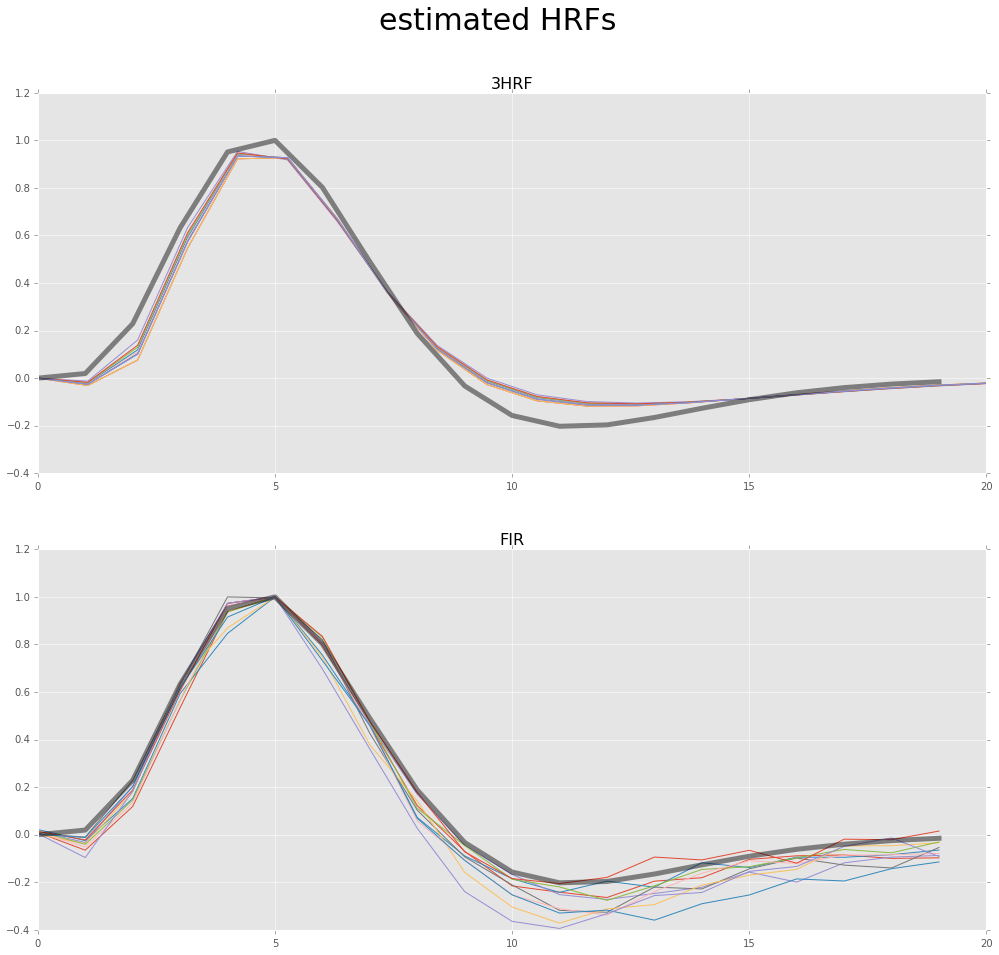

In [14]:
rcParams['figure.figsize'] = 17, 15
random_voxels = np.random.randint(0,high=n_voxels,size=100)

xx = np.linspace(0, 20,num=20) # range of values for time
generated_hrfs = hrfs[0] * he.hrf.spmt(xx)[:, None] + hrfs[1] * he.hrf.dspmt(xx)[:, None] + hrfs[2] * he.hrf.ddspmt(xx)[:, None]
print hrfs[0].shape
voxels = np.arange(0,n_voxels)
fig = plt.figure()
fig.suptitle('estimated HRFs',fontsize=30)
ax = plt.subplot(211)
ax.set_title('3HRF',fontsize=16)
ax.plot(xx,generated_hrfs)
ax.plot(h,'k',linewidth=5,alpha = .45)

xx = np.arange(hrf_len) # range of values for time
ax = plt.subplot(212)
ax.set_title('FIR',fontsize=16)
ax.plot(flexi_hrfs)
ax.plot(h,'k',linewidth=5,alpha = .45)
plt.show()

In [15]:
generated_hrfs = hrfs[0]*he.hrf.ddspmt(xx)[:, None] + hrfs[1] * he.hrf.dspmt(xx)[:, None] + hrfs[2] * he.hrf.ddspmt(xx)[:, None]
print generated_hrfs.shape

(20, 10)


#histrogram of beta weights

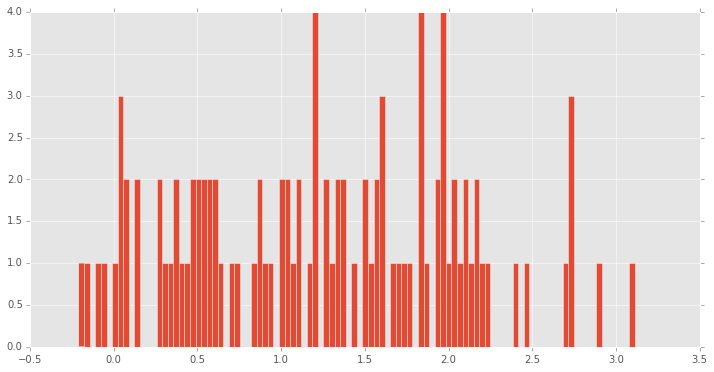

In [16]:

plt.figure(figsize=(12, 6))
plt.hist(flexi_betas.ravel(),bins=100)
plt.show()


# FIR R^2s

In [17]:
x = design_matrix
flexi_r_hats = []

# building estimated signal
for i in xrange(n_voxels):
    h_e = flexi_hrfs[:,i]
    b = flexi_betas[:,i]
    xh = convolve2d(x,np.reshape(h_e,(len(h_e),1)))
    print xh.shape
    flexi_r_hats.append(np.dot(xh,np.reshape(b,len(b),1))[:n_vols])
    
for i in xrange(n_voxels):
    r = df.voxels[i]
    r_hat = flexi_r_hats[i] 
    r_bar = np.mean(r)
    s1 = np.sum( [ (r[j] - r_hat[j] ) ** 2 for j in xrange(len(r))])
    s2 = np.sum( [ (r[k] - r_bar    ) ** 2 for k in xrange(len(r))])

    print 'voxel {} R^2 = {}'.format(i,np.round(((1- s1 / s2) * 100),2))
    



(219, 10)
(219, 10)
(219, 10)
(219, 10)
(219, 10)
(219, 10)
(219, 10)
(219, 10)
(219, 10)
(219, 10)
voxel 0 R^2 = 57.96
voxel 1 R^2 = -87.5
voxel 2 R^2 = -42.8
voxel 3 R^2 = -11.39
voxel 4 R^2 = 23.99
voxel 5 R^2 = -171.78
voxel 6 R^2 = -33.04
voxel 7 R^2 = -75.93
voxel 8 R^2 = 62.72
voxel 9 R^2 = 61.52


# 3HRF R^2s


In [18]:
r_hats = []

# building estimated signal
for i in xrange(n_voxels):
    h_e = generated_hrfs[:,i]## apply basis functions here?
    b = betas[:,i]
    xh = convolve2d(x,np.reshape(h_e,(len(h_e),1)))
    r_hats.append(np.dot(xh,np.reshape(b,len(b),1))[:n_vols])
    
for i in xrange(n_voxels):
    r = df.voxels[i] # original signal, detrended
    r_hat = r_hats[i] 
    r_bar = np.mean(r) 
    s1 = np.sum([(r[j] - r_hat[j]) ** 2 for j in xrange(len(r))])
    s2 = np.sum([(r[k] - r_bar) ** 2 for k in xrange(len(r))])
    print 'voxel {} R^2 = {}'.format(i,np.round(((1- s1 / s2) * 100),2))
    



voxel 0 R^2 = -70.31
voxel 1 R^2 = -158.63
voxel 2 R^2 = -111.8
voxel 3 R^2 = -145.25
voxel 4 R^2 = -119.99
voxel 5 R^2 = -215.27
voxel 6 R^2 = -113.38
voxel 7 R^2 = -97.39
voxel 8 R^2 = -53.25
voxel 9 R^2 = -82.62


# Original Signal v. estimated signal

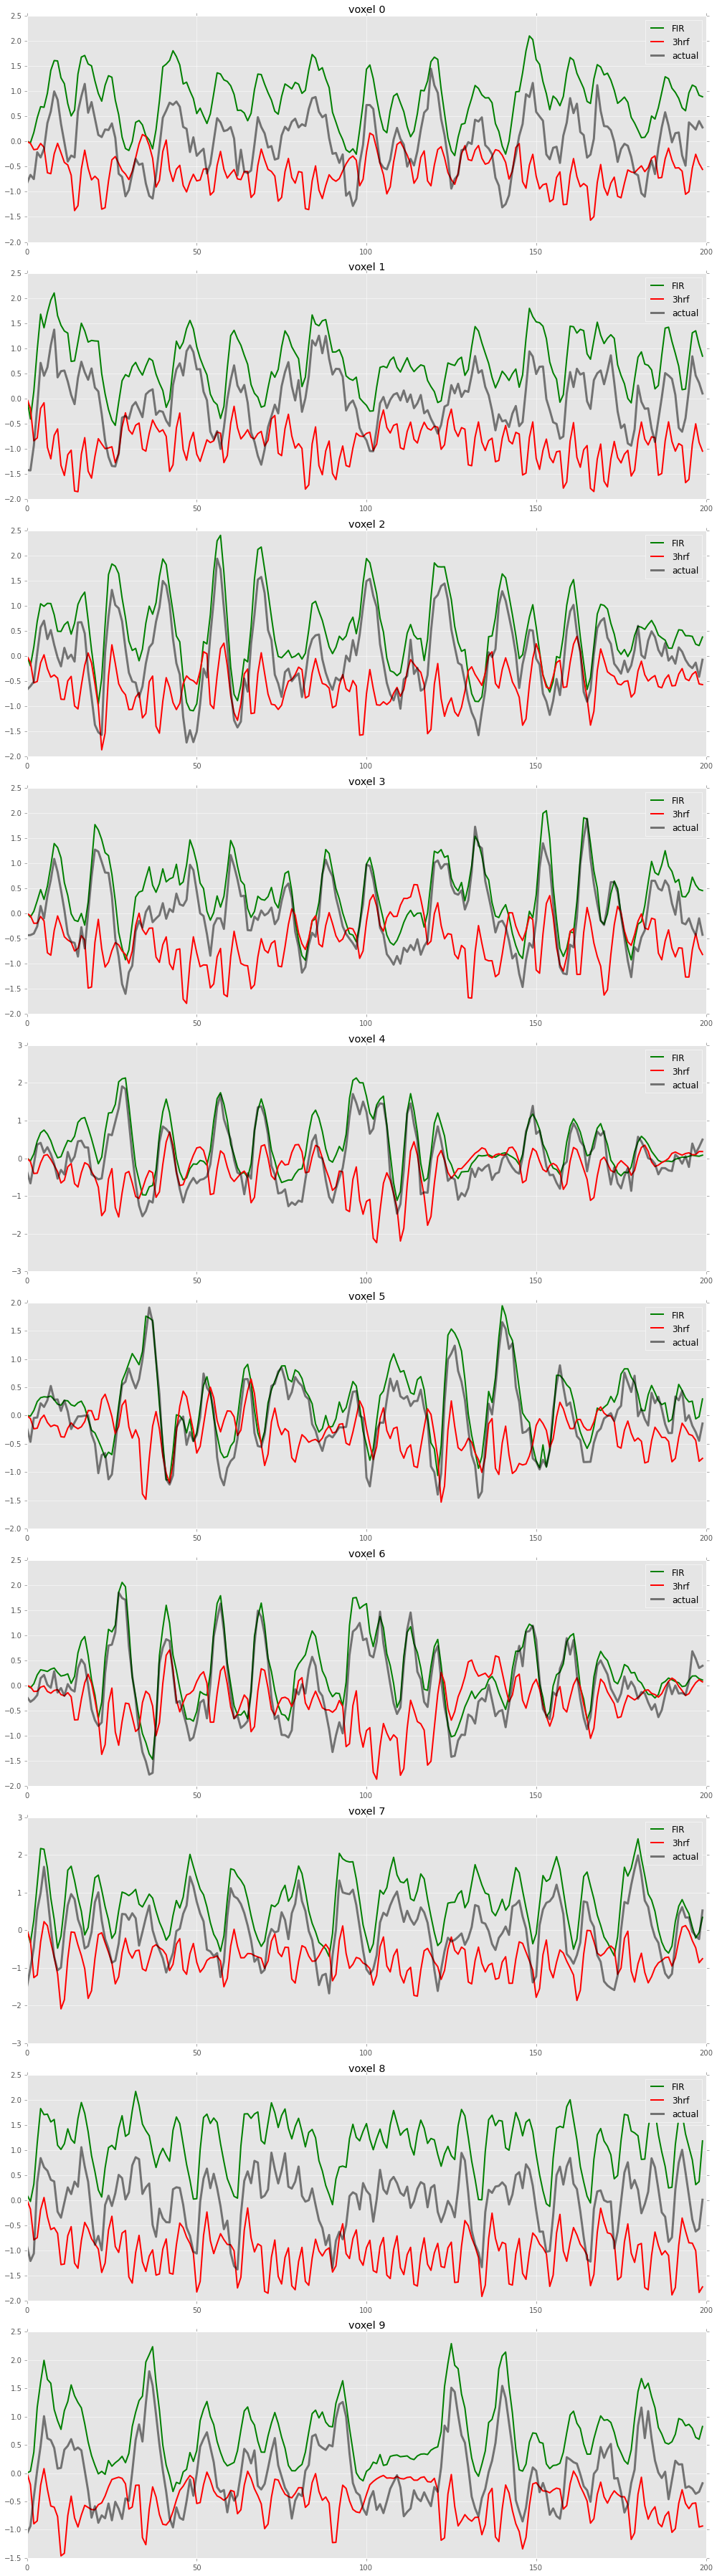

In [62]:
vfig = plt.figure()

rcParams['figure.figsize'] = 14, 50

for i in xrange(n_voxels):
    plt.legend()
    time = np.arange(0,n_vols*TR,TR)
    ax = plt.subplot(n_voxels,1,i + 1)
    ax.set_title('voxel {}'.format(i))
    ax.plot(time,flexi_r_hats[i][:len(time)],'g',label='FIR',lw=2)
    ax.plot(r_hats[i],'r',label='3hrf',lw=2)
    ax.plot(time,df.voxels[i],'k',label='actual',alpha=.5,lw=3)
    vfig.tight_layout()
vfig.show()

# Questions:
* What to do with the mean betas?
* the signal that comes out is hrf_len longer than the original?
* should detrending be fit iterively somehow or just use same params for everything?
* why does 3hrf looks so useless

TypeError: array([ 22.,  34.]) is not JSON serializable

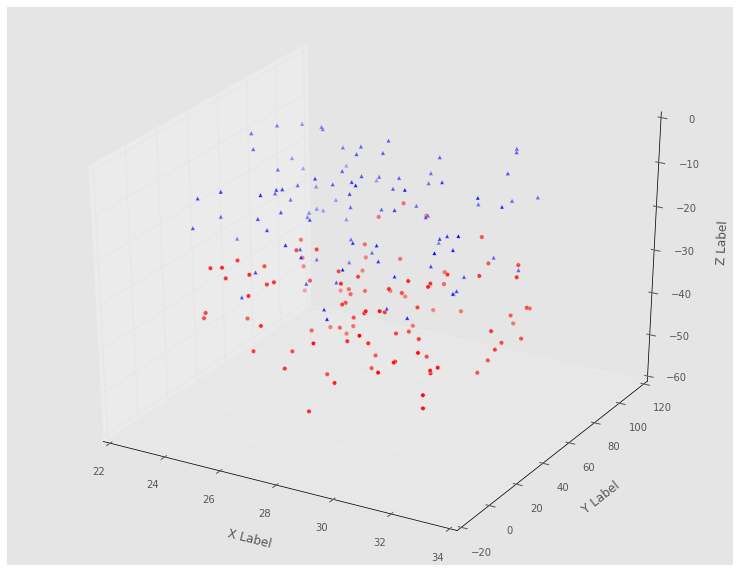

In [26]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def randrange(n, vmin, vmax):
    return (vmax-vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zl, zh)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

